# Clipping a Grid


Example of how to use `rioxarray` to clip the drainage basins from Antarctica

In [12]:
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray

from cartopy import crs as ccrs#, feature as cfeature
from matplotlib import pyplot as plt
import matplotlib.path as mpath

In [4]:
# Download dataset
url='https://icesat4.gsfc.nasa.gov/cryo_data/drainage_divides/Ant_Grounded_DrainageSystem_Polygons.txt'
name = 'zwally_ANT_drainage_basins'

# read txt 
df = pd.read_csv(url,
                     header=6,sep='\s+')

df.columns=['lat','lon','id']
# re-order df:
df=df[['lon','lat','id']]
print(df.head())

         END         OF  HEADER
0 -74.525273 -61.122545       1
1 -74.525435 -61.123664       1
2 -74.525467 -61.123826       1
3 -74.525576 -61.124568       1
4 -74.525609 -61.124498       1


In [9]:
# open etopo dataset
ds=xr.open_dataset('/Users/ccamargo/Documents/github/oceanmass_SLF_local/data/ETOPO1_Ice-180x360.nc')
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    z        (lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  COARDS/CF-1.0
    history:      Thu Apr 15 17:04:48 2021: cdo remapbil,r360x180 ETOPO1_Ice_...
    title:        ETOPO1_Ice_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


In [11]:
# creade dataarray to clip:
xda = xr.DataArray(data=ds.z, 
                       dims=["y", "x"], 
                       coords=dict(x=(["x"], ds.lon),
                                   y=(["y"], ds.lat)))
# Convert longitudes to -180 to 180
xda = xda.assign_coords(x=(((xda.x + 180) % 360) - 180))
# # Order longitudes 
xda = xda.sortby('x')
#% %
# Set the projection
# proj="EPSG:3031" #EPSG:3031: WGS 84 / Antarctic Polar Stereographic
proj="EPSG:4326"
xda=xda.rio.write_crs(proj)

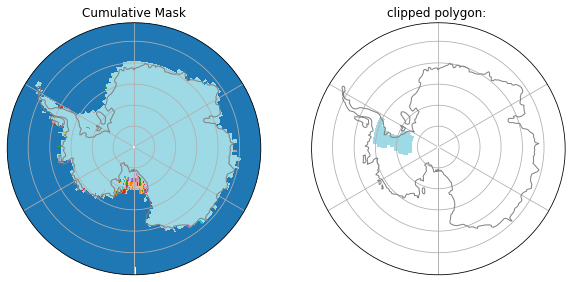

In [17]:
# %% test with one basin
df2=df[df['id']==1]
df2=df2.drop(['id'],axis=1)
coords = df2.values.tolist()
geometries = [{'type': 'Polygon','coordinates': [coords]}]
clipped = xda.rio.clip(geometries)
#% %
#% % plot
fig = plt.figure(figsize=(10,10), facecolor='w')
theta = np.linspace(0, 2*np.pi, 100);center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T;circle = mpath.Path(verts * radius + center)
ax1 = plt.subplot(1, 2, 1, 
                  # projection=ccrs.Robinson())
                    projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines(resolution='110m', zorder=3,color='grey') # zorder=3 makes sure that no other plots overlay the coastlines
ax1.gridlines()
ax1.set_boundary(circle, transform=ax1.transAxes)
plt.pcolormesh(xda.x,xda.y,
                # ds.mask, 
                xda.data,
                # clipped,
                # ds.mask,
                # cmap='twilight',
                cmap='tab20',
                vmin=0,vmax=20,
                #extent=(0,1,0,1), origin='lower',
            transform=ccrs.PlateCarree()
            )
plt.title('Cumulative Mask')

ax1 = plt.subplot(1, 2, 2, 
                  # projection=ccrs.Robinson())
                    projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines(resolution='110m', zorder=3,color='grey') # zorder=3 makes sure that no other plots overlay the coastlines
ax1.gridlines()


ax1.set_boundary(circle, transform=ax1.transAxes)
plt.pcolormesh(clipped.x,clipped.y,
                # ds.mask, 
                # rda.data,
                clipped,
                # ds.mask,
                cmap='tab20',
                vmin=0,vmax=20,
                #extent=(0,1,0,1), origin='lower',
            transform=ccrs.PlateCarree()
            )
plt.title('clipped polygon: ')

plt.show()

In [18]:
#%% clip every basin
data=np.full_like(np.array(ds.z),0)
xda2 = xr.DataArray(data=data, 
                       dims=["y", "x"], 
                       coords=dict(x=(["x"], xda.x),
                                   y=(["y"], xda.y)))

for i in np.unique(df['id']):
    print(i)
    df2=df[df['id']==i]
    df2=df2.drop(['id'],axis=1)
    coords = df2.values.tolist()
    if i==17 :
        # values after 180:
        df3= df2.drop(df2[(df2['lon'] >= 0)  ].index)
        df3['lon'][df3['lon'].idxmin()]=-180
        df3['lat'][df3['lat'].idxmin()]=-90
        coords = df3.values.tolist()
        geometries = [{'type': 'Polygon','coordinates': [coords]}]
        clipped = xda.rio.clip(geometries)
        clipped.data[np.isfinite(clipped.data)]=i
        clipped=clipped.fillna(0)
        xda2=xr.concat([xda2,clipped],dim=['y','x'])
        xda2=xda2.fillna(0)
        xda2=xda2.sum(dim='concat_dim')
        # values before 180:
        df3= df2.drop(df2[(df2['lon'] <= 0)  ].index)
        df3['lon'][df3['lon'].idxmin()]=-180
        df3['lat'][df3['lat'].idxmin()]=-90
        coords = df3.values.tolist()
        geometries = [{'type': 'Polygon','coordinates': [coords]}]
        clipped = xda.rio.clip(geometries)
        clipped.data[np.isfinite(clipped.data)]=i
        clipped=clipped.fillna(0)
        xda2=xr.concat([xda2,clipped],dim=['y','x'])
        xda2=xda2.fillna(0)
        xda2=xda2.sum(dim='concat_dim')
    else:  
        coords = df2.values.tolist()
        # Build the geometries object
        geometries = [{'type': 'Polygon','coordinates': [coords]}]
        clipped = xda.rio.clip(geometries)
        clipped.data[np.isfinite(clipped.data)]=i
        clipped=clipped.fillna(0)
        xda2=xr.concat([xda2,clipped],dim=['y','x'])
        xda2=xda2.fillna(0)
        xda2=xda2.sum(dim='concat_dim')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


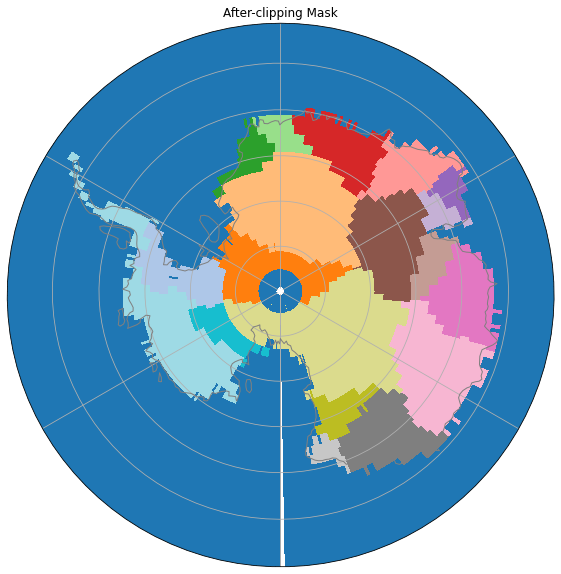

In [20]:
#%%%% plot
fig = plt.figure(figsize=(10,10), facecolor='w')
theta = np.linspace(0, 2*np.pi, 100);center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T;circle = mpath.Path(verts * radius + center)
ax1 = plt.subplot(1, 1, 1, 
                  # projection=ccrs.Robinson())
                    projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines(resolution='110m', zorder=3,color='grey') # zorder=3 makes sure that no other plots overlay the coastlines
ax1.gridlines()
ax1.set_boundary(circle, transform=ax1.transAxes)
plt.pcolormesh(xda2.x,xda2.y,
                # ds.mask, 
                xda2.data,
                # clipped,
                # ds.mask,
                # cmap='twilight',
                cmap='tab20',
                vmin=0,vmax=20,
                #extent=(0,1,0,1), origin='lower',
            transform=ccrs.PlateCarree()
            )
plt.title('After-clipping Mask')

plt.show()

In [21]:
#%% # fill inner circle:
lat=np.array(xda2.y)
lon=np.array(xda2.x)
mask=np.array(xda2.data)
llon,llat=np.meshgrid(lon,lat)
df=pd.DataFrame(llon.flatten(),columns=['lon'])
df['lat']=llat.flatten()
df['z']=mask.flatten()
#% %
df['z']=np.where(((df['z']==0) & (df['lat']<-85) #& (df['lon']<120)
                  )
                 ,2,df['z'])


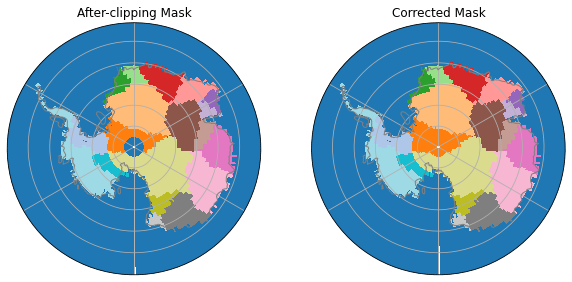

In [22]:
#%%%% plot
fig = plt.figure(figsize=(10,10), facecolor='w')
theta = np.linspace(0, 2*np.pi, 100);center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T;circle = mpath.Path(verts * radius + center)
ax1 = plt.subplot(1, 2, 1, 
                  # projection=ccrs.Robinson())
                    projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines(resolution='110m', zorder=3,color='grey') # zorder=3 makes sure that no other plots overlay the coastlines
ax1.gridlines()
ax1.set_boundary(circle, transform=ax1.transAxes)
plt.pcolormesh(xda2.x,xda2.y,
                # ds.mask, 
                xda2.data,
                # clipped,
                # ds.mask,
                # cmap='twilight',
                cmap='tab20',
                vmin=0,vmax=20,
                #extent=(0,1,0,1), origin='lower',
            transform=ccrs.PlateCarree()
            )
plt.title('After-clipping Mask')

ax1 = plt.subplot(1, 2, 2, 
                  # projection=ccrs.Robinson())
                    projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines(resolution='110m', zorder=3,color='grey') # zorder=3 makes sure that no other plots overlay the coastlines
ax1.gridlines()


ax1.set_boundary(circle, transform=ax1.transAxes)
plt.pcolormesh(np.array(df['lon']).reshape(180,360)[0,:],
               np.array(df['lat']).reshape(180,360)[:,0],
               np.array(df['z']).reshape(180,360),
               
                # xda2.x,xda2.y,
                # xda2.data,
                cmap='tab20',
                vmin=0,vmax=20,
                #extent=(0,1,0,1), origin='lower',
            transform=ccrs.PlateCarree()
            )
plt.title('Corrected Mask')

plt.show()